In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.utils import to_categorical

In [2]:
cwd = os.getcwd()
cwd

'/Users/silvana/Documents/Projects/TrafficSigns'

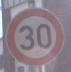

In [3]:
img = Image.open('82373-191501-bundle-archive/Train/1/00001_00000_00016.png')
img

Data is organized in train, test, and meta folders. The train folder contains 43 subfolders (corresponding to the 43 different classes), each containing images from the respective class. The test folder contains images that need to be classified. In the meta folder we find sign images. 

First step is to combine the images in the training dataset in two lists -- one containing the image name and the other one containing its label. 

In [4]:
images = []
labels = []

for i in range(43):
    class_path = cwd + '/82373-191501-bundle-archive/Train/' + str(i)
    class_folder = os.listdir(class_path)
    
    for img in class_folder:
        img = Image.open(class_path + '/' + img)
        img = np.array(img)
        images.append(img)
        labels.append(i)

The most powerful models for handling image data are CNNs. Before feeding the images into such a model, we want to make sure they are of the same size.

In [5]:
min_width = 10**6
max_width = 0
min_height = 10**6
max_height = 0;
channels = 10

for i in range(len(images)):
    if images[i].shape[0]  < min_width: 
        min_width = images[i].shape[0]
    if images[i].shape[0]  > max_width: 
        max_width = images[i].shape[0]
    if images[i].shape[1]  < min_height: 
        min_height = images[i].shape[1]
    if images[i].shape[1]  > max_height: 
        max_height = images[i].shape[1]
    if images[i].shape[2]  < channels: 
        channels = images[i].shape[2]

In [6]:
print('min/max width:', min_width, max_width)
print('min/max height:', min_height, max_height)
print('min number of channels:', channels)

min/max width: 25 225
min/max height: 25 243
min number of channels: 3


Since both *min_width* and *min_height* are 25, we are going to resize all images to be of shape 25x25 pixels. All images in the data size have 3 channels, i.e. are colorful images.

In [7]:
images_resized = []

for i in range(len(images)):
    images_resized.append(resize(images[i], (25, 25)))
    
images_resized = np.array(images_resized)

In [8]:
# converto to numpy arrays
images_resized = np.array(images_resized)
labels = np.array(labels)

print(images_resized.shape, labels.shape)

(39209, 25, 25, 3) (39209,)


In [9]:
# convert the classes into a categorical variable
labels = to_categorical(labels, 43)

# Modeling

In [10]:
# split into train and test datasets
images_train, images_valid, labels_train, labels_valid = train_test_split(images_resized, labels, 
                                                                        test_size=0.2, random_state=7)

In [36]:
# build the model
input_shape = images_train[0].shape

model = Sequential()
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))

In [37]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
print(images_train.shape, labels_train.shape)
print(images_valid.shape, labels_valid.shape)

(31367, 25, 25, 3) (31367, 43)
(7842, 25, 25, 3) (7842, 43)


In [39]:
# train and validate the model
history = model.fit(images_train, labels_train, batch_size=64, epochs=50, validation_data=(images_valid, labels_valid))

Epoch 1/50
491/491 [==============================] - 34s 70ms/step - loss: 1.5083 - accuracy: 0.5988 - val_loss: 0.4971 - val_accuracy: 0.8704
Epoch 2/50
491/491 [==============================] - 46s 94ms/step - loss: 0.3058 - accuracy: 0.9228 - val_loss: 0.2237 - val_accuracy: 0.9472
Epoch 3/50
491/491 [==============================] - 51s 104ms/step - loss: 0.1626 - accuracy: 0.9603 - val_loss: 0.1852 - val_accuracy: 0.9522
Epoch 4/50
491/491 [==============================] - 53s 108ms/step - loss: 0.1056 - accuracy: 0.9745 - val_loss: 0.1258 - val_accuracy: 0.9742
Epoch 5/50
491/491 [==============================] - 50s 102ms/step - loss: 0.0771 - accuracy: 0.9813 - val_loss: 0.1107 - val_accuracy: 0.9768
Epoch 6/50
491/491 [==============================] - 49s 100ms/step - loss: 0.0585 - accuracy: 0.9861 - val_loss: 0.1047 - val_accuracy: 0.9778
Epoch 7/50
491/491 [==============================] - 48s 97ms/step - loss: 0.0454 - accuracy: 0.9885 - val_loss: 0.1214 - val_accur

# plot loss
plt.figure()
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()

#plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend();

# Test the model with unseen data

In [42]:
data_test = pd.read_csv('82373-191501-bundle-archive/Test.csv')
data_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [51]:
test_img_files = data_test['Path']
labels_test = data_test['ClassId']

In [48]:
# read in and resize the images
images = []

for img in test_img_files:
    img = Image.open(cwd + '/82373-191501-bundle-archive/' + img)
    img = img.resize((25,25))
    img = np.array(img)
    images.append(img)

In [50]:
images_test = np.array(images)

In [54]:
# predict on the test dataset
pred_labels = model.predict_classes(images_test)

In [55]:
accuracy_score(labels_test, pred_labels)

0.9364212193190815

In [56]:
model.save('TraficSigns.h5')